## &#x1F310; &nbsp; Code Library, Style, and Links
The previous notebooks:

&#x1F310; &nbsp; [PASSNYC. Data Exploration](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration)

&#x1F310; &nbsp; [PASSNYC. Numeric and Categorical Variables](https://www.kaggle.com/olgabelitskaya/passnyc-numeric-and-categorical-variables)

&#x1F310; &nbsp; [PASSNYC. Comparing All Districts with 5th District](passnyc-comparing-all-districts-with-5th-district)

&#x1F310; &nbsp; [PASSNYC. Regression Methods](https://www.kaggle.com/olgabelitskaya/passnyc-regression-methods)

Useful Links:

[School Quality Reports. Educator Guide](http://schools.nyc.gov/NR/rdonlyres/967E0EE1-7E5D-4E47-BC21-573FEEE23AE2/0/201516EducatorGuideHS9252017.pdf)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #37c9e1; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}               
</style>

In [2]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from descartes import PolygonPatch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score

from keras.models import Sequential, load_model, Model
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
def scores(regressor, y_train, y_valid, y_test, y_train_reg, y_valid_reg, y_test_reg):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score. Train: ", explained_variance_score(y_train, y_train_reg))
    print("EV score. Valid: ", explained_variance_score(y_valid, y_valid_reg))
    print("EV score. Test: ", explained_variance_score(y_test, y_test_reg))
    print("---------")
    print("R2 score. Train: ", r2_score(y_train, y_train_reg))
    print("R2 score. Valid: ", r2_score(y_valid, y_valid_reg))
    print("R2 score. Test: ", r2_score(y_test, y_test_reg))
    print("---------")
    print("MSE score. Train: ", mean_squared_error(y_train, y_train_reg))
    print("MSE score. Valid: ", mean_squared_error(y_valid, y_valid_reg))
    print("MSE score. Test: ", mean_squared_error(y_test, y_test_reg))
    print("---------")
    print("MAE score. Train: ", mean_absolute_error(y_train, y_train_reg))
    print("MAE score. Valid: ", mean_absolute_error(y_valid, y_valid_reg))
    print("MAE score. Test: ", mean_absolute_error(y_test, y_test_reg))
    print("---------")
    print("MdAE score. Train: ", median_absolute_error(y_train, y_train_reg))
    print("MdAE score. Valid: ", median_absolute_error(y_valid, y_valid_reg))
    print("MdAE score. Test: ", median_absolute_error(y_test, y_test_reg))
    
def loss_plot(fit_history, n):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['loss'][n:], 
             color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], 
             color='#37c9e1', label = 'valid')

    plt.legend()
    plt.title('Loss Function');  
    
def mae_plot(fit_history, n):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['mean_absolute_error'][n:], 
             color='slategray', label = 'train')
    plt.plot(fit_history.history['val_mean_absolute_error'][n:], 
             color='#37c9e1', label = 'valid')

    plt.legend()
    plt.title('Mean Absolute Error');

In [4]:
style_dict = {'background-color':'slategray',
              'color':'#37c9e1',
              'border-color': 'white'}

## &#x1F310; &nbsp; Load and Preprocess the Data

In [6]:
school_explorer = pd.read_csv('2016 School Explorer.csv')
d5_shsat = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
school_explorer.shape, d5_shsat.shape

((1272, 161), (140, 7))

In [7]:
# Fillna or replace values
numeric_list = list(school_explorer\
.columns[[7,8]+list(range(16,27))+[28,30,32,34,36]+list(range(41,161))])
target_list = ['Average ELA Proficiency','Average Math Proficiency']

school_explorer = school_explorer.drop(['Adjusted Grade',
                                        'New?',
                                        'Other Location Code in LCGMS'], 
                                       axis=1)
school_explorer.loc[[427,1023,712,908],'School Name'] = \
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']

percent_list = ['Percent ELL','Percent Asian','Percent Black',
                'Percent Hispanic','Percent Black / Hispanic',
                'Percent White','Student Attendance Rate',
                'Percent of Students Chronically Absent',
                'Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %',
                'Strong Family-Community Ties %','Trust %']

for el in percent_list:
    school_explorer[el] = school_explorer[el].astype('str')
    school_explorer[el] = school_explorer[el].str.replace("%", "")
    school_explorer[el] = school_explorer[el].str.replace("nan", "0")
    school_explorer[el] = school_explorer[el].astype(float)
    school_explorer[el].replace(0, np.NaN, inplace=True)
    school_explorer[el] = school_explorer[el].interpolate()
    
school_explorer['Economic Need Index'] = \
school_explorer['Economic Need Index'].interpolate()
school_explorer['Average ELA Proficiency'] = \
school_explorer['Average ELA Proficiency'].interpolate()
school_explorer['Average Math Proficiency'] = \
school_explorer['Average Math Proficiency'].interpolate()

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate'] = \
    school_explorer['School Income Estimate'].str.replace(s, "")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].str.replace("nan", "0")

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0, np.NaN, inplace=True)
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].interpolate()

rating_list = ['Rigorous Instruction Rating','Collaborative Teachers Rating',
               'Supportive Environment Rating','Effective School Leadership Rating',
               'Strong Family-Community Ties Rating','Strong Family-Community Ties Rating',
               'Trust Rating','Student Achievement Rating']

for el in rating_list:
    moda_value = school_explorer[el].value_counts().idxmax()
    school_explorer[el] = school_explorer[el].fillna(moda_value) 
    
category_list1 = ['District','Community School?','City','Grades']
                  
category_list2 = ['Rigorous Instruction Rating',
                  'Collaborative Teachers Rating',
                  'Supportive Environment Rating',
                  'Effective School Leadership Rating',
                  'Strong Family-Community Ties Rating',
                  'Trust Rating','Student Achievement Rating']

for feature in category_list1:
    feature_cat = pd.factorize(school_explorer[feature])
    school_explorer[feature] = feature_cat[0]
    
for feature in category_list2:
    feature_pairs = dict(zip(['Not Meeting Target', 'Meeting Target', 
                              'Approaching Target', 'Exceeding Target'],
                             ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature] = school_explorer[feature].astype(int)
    
category_list = list(category_list1+category_list2)
    
print('NaN count = ', sum(school_explorer.isna().sum()))  

NaN count =  0


In [8]:
# Merge two datasets
d5_shsat_2016 = d5_shsat[['DBN','Number of students who registered for the SHSAT',
                          'Number of students who took the SHSAT']][d5_shsat['Year of SHST']==2016]\
.groupby(['DBN'],as_index=False).agg(np.sum)

d5_shsat_2016['Took SHSAT %'] = d5_shsat_2016['Number of students who took the SHSAT']\
/d5_shsat_2016['Number of students who registered for the SHSAT']

d5_shsat_2016['Took SHSAT %'] = d5_shsat_2016['Took SHSAT %'].fillna(0).apply(lambda x: round(x,3))
d5_shsat_2016.rename(columns={'DBN':'Location Code'}, inplace=True)

d5_shsat_2016 = pd.merge(school_explorer[['Location Code']+numeric_list+target_list],
                         d5_shsat_2016, 
                         on='Location Code')
d5_shsat_2016.shape

(21, 144)

## &#x1F310; &nbsp; Split the Data for Neural Networks Training
The predictions of economic indicators for schools are based on the data about social environment, ethnic composition and educational results.

#### The first set of features and targets

In [7]:
# data = school_explorer
# features = numeric veriables+target_list-economic_indicators, targets = Economic Need Index
features = school_explorer[numeric_list+target_list]\
.drop(['Economic Need Index','School Income Estimate'], axis=1).values
targets = school_explorer['Economic Need Index'].values

X_train1, X_test1, y_train1, y_test1 = \
train_test_split(features, targets, test_size=0.3, random_state=1)

n = int(len(X_test1)/2)
X_valid1, y_valid1 = X_test1[:n], y_test1[:n]
X_test1, y_test1 = X_test1[n:], y_test1[n:]
X_train1.shape, X_test1.shape, X_valid1.shape, y_train1.shape, y_test1.shape, y_valid1.shape

((890, 138), (191, 138), (191, 138), (890,), (191,), (191,))

#### The second set of features and targets

In [8]:
# data = school_explorer
# features = numeric veriables+target_list-economic_indicators, targets = School Income Estimate
features = school_explorer[numeric_list+target_list]\
.drop(['Economic Need Index','School Income Estimate'], axis=1).values
targets = school_explorer['School Income Estimate'].values

X_train2, X_test2, y_train2, y_test2 = \
train_test_split(features, targets, test_size=0.3, random_state=1)

n = int(len(X_test2)/2)
X_valid2, y_valid2 = X_test2[:n], y_test2[:n]
X_test2, y_test2 = X_test2[n:], y_test2[n:]

scale_y2 = RobustScaler()
y_train2 = scale_y2.fit_transform(y_train2.reshape(-1,1))
y_valid2 = scale_y2.transform(y_valid2.reshape(-1,1))
y_test2 = scale_y2.transform(y_test2.reshape(-1,1))

X_train2.shape, X_test2.shape, X_valid2.shape, y_train2.shape, y_test2.shape, y_valid2.shape

((890, 138), (191, 138), (191, 138), (890, 1), (191, 1), (191, 1))

## &#x1F310; &nbsp; Neural Network Regressors
### MLP
#### The first set of features and targets

In [9]:
def mlp_model1():
    model = Sequential()
    
    model.add(Dense(138, input_dim=138))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

mlp_model1 = mlp_model1()

In [10]:
mlp_checkpointer1 = ModelCheckpoint(filepath='mlp_model1.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
mlp_lr_reduction1 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [11]:
mlp_history1 = mlp_model1.fit(X_train1, y_train1, 
                              epochs=35, batch_size=16, verbose=2,
                              validation_data=(X_valid1, y_valid1),
                              callbacks=[mlp_checkpointer1,mlp_lr_reduction1])

Train on 890 samples, validate on 191 samples
Epoch 1/35
 - 5s - loss: 1177.3387 - mean_absolute_error: 8.2026 - val_loss: 26.3334 - val_mean_absolute_error: 4.5123

Epoch 00001: val_loss improved from inf to 26.33343, saving model to mlp_model1.passnyc.hdf5
Epoch 2/35
 - 1s - loss: 7.6321 - mean_absolute_error: 1.8362 - val_loss: 0.6117 - val_mean_absolute_error: 0.3558

Epoch 00002: val_loss improved from 26.33343 to 0.61167, saving model to mlp_model1.passnyc.hdf5
Epoch 3/35
 - 1s - loss: 0.5986 - mean_absolute_error: 0.4707 - val_loss: 0.0466 - val_mean_absolute_error: 0.1361

Epoch 00003: val_loss improved from 0.61167 to 0.04660, saving model to mlp_model1.passnyc.hdf5
Epoch 4/35
 - 1s - loss: 0.1766 - mean_absolute_error: 0.3047 - val_loss: 0.0696 - val_mean_absolute_error: 0.2194

Epoch 00004: val_loss did not improve from 0.04660
Epoch 5/35
 - 1s - loss: 0.1213 - mean_absolute_error: 0.2618 - val_loss: 0.0551 - val_mean_absolute_error: 0.1829

Epoch 00005: val_loss did not imp

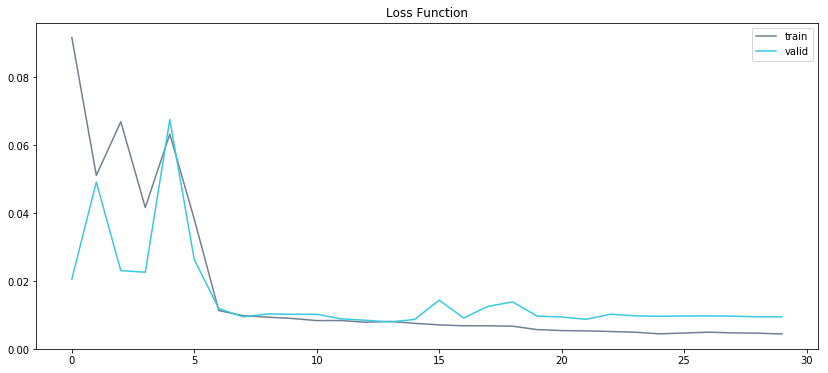

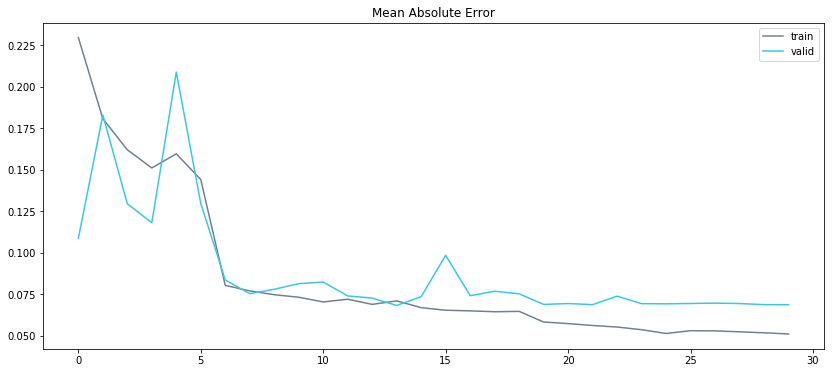

In [12]:
loss_plot(mlp_history1,5)
mae_plot(mlp_history1,5)

In [13]:
mlp_model1.load_weights('mlp_model1.passnyc.hdf5')

y_train_mlp1 = mlp_model1.predict(X_train1)
y_valid_mlp1 = mlp_model1.predict(X_valid1)
y_test_mlp1 = mlp_model1.predict(X_test1)

scores('MLP; Economic Need Index', 
       y_train1, y_valid1, y_test1, y_train_mlp1, y_valid_mlp1, y_test_mlp1)

_______________________________________
MLP; Economic Need Index
_______________________________________
EV score. Train:  0.8700018501462249
EV score. Valid:  0.8487094568092367
EV score. Test:  0.8155795419161712
---------
R2 score. Train:  0.8611007318623091
R2 score. Valid:  0.8456730912417543
R2 score. Test:  0.8031009592759996
---------
MSE score. Train:  0.005853595898570131
MSE score. Valid:  0.008007837169116546
MSE score. Test:  0.008589245197693551
---------
MAE score. Train:  0.059034425914756376
MAE score. Valid:  0.06821135378320803
MAE score. Test:  0.0720620555356535
---------
MdAE score. Train:  0.04750646734237668
MdAE score. Valid:  0.050115415334701485
MdAE score. Test:  0.06154771995544439


#### The second set of features targets

In [14]:
def mlp_model2():
    model = Sequential()
    
    model.add(Dense(138, input_dim=138))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138*8))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

mlp_model2 = mlp_model2()

In [15]:
mlp_checkpointer2 = ModelCheckpoint(filepath='mlp_model2.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
mlp_lr_reduction2 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [16]:
mlp_history2 = mlp_model2.fit(X_train2, y_train2, 
                              epochs=35, batch_size=16, verbose=2,
                              validation_data=(X_valid2, y_valid2),
                              callbacks=[mlp_checkpointer2,mlp_lr_reduction2])

Train on 890 samples, validate on 191 samples
Epoch 1/35
 - 2s - loss: 1708.3665 - mean_absolute_error: 8.4594 - val_loss: 6.3720 - val_mean_absolute_error: 2.2670

Epoch 00001: val_loss improved from inf to 6.37204, saving model to mlp_model2.passnyc.hdf5
Epoch 2/35
 - 1s - loss: 18.3476 - mean_absolute_error: 2.2200 - val_loss: 3.3266 - val_mean_absolute_error: 0.8799

Epoch 00002: val_loss improved from 6.37204 to 3.32662, saving model to mlp_model2.passnyc.hdf5
Epoch 3/35
 - 1s - loss: 1.9568 - mean_absolute_error: 0.9302 - val_loss: 0.7096 - val_mean_absolute_error: 0.6358

Epoch 00003: val_loss improved from 3.32662 to 0.70960, saving model to mlp_model2.passnyc.hdf5
Epoch 4/35
 - 1s - loss: 1.2897 - mean_absolute_error: 0.7016 - val_loss: 0.6876 - val_mean_absolute_error: 0.5932

Epoch 00004: val_loss improved from 0.70960 to 0.68761, saving model to mlp_model2.passnyc.hdf5
Epoch 5/35
 - 1s - loss: 0.5802 - mean_absolute_error: 0.5585 - val_loss: 0.4607 - val_mean_absolute_error

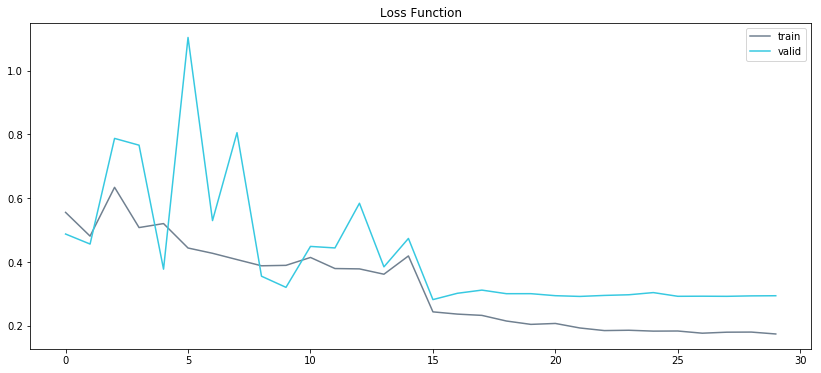

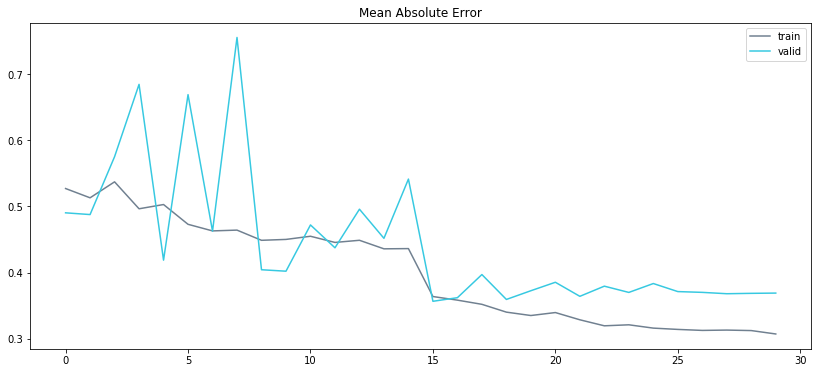

In [17]:
loss_plot(mlp_history2,5)
mae_plot(mlp_history2,5)

In [18]:
mlp_model2.load_weights('mlp_model2.passnyc.hdf5')

y_train_mlp2 = mlp_model2.predict(X_train2)
y_valid_mlp2 = mlp_model2.predict(X_valid2)
y_test_mlp2 = mlp_model2.predict(X_test2)

scores('MLP; School Income Estimate', 
       y_train2, y_valid2, y_test2, y_train_mlp2, y_valid_mlp2, y_test_mlp2)

_______________________________________
MLP; School Income Estimate
_______________________________________
EV score. Train:  0.7157194566448815
EV score. Valid:  0.6770958571099446
EV score. Test:  0.5961741005636607
---------
R2 score. Train:  0.7119403108986957
R2 score. Valid:  0.6757007183604411
R2 score. Test:  0.5961096058229234
---------
MSE score. Train:  0.2129918910499741
MSE score. Valid:  0.28211148400690417
MSE score. Test:  0.26874958585287567
---------
MAE score. Train:  0.33469084872005067
MAE score. Valid:  0.35640059841503563
MAE score. Test:  0.38129183190242794
---------
MdAE score. Train:  0.2521512458610572
MdAE score. Valid:  0.251754443816836
MdAE score. Test:  0.28999568721213975


### CNN
#### The first set of features and targets

In [64]:
def cnn_model1():
    model = Sequential()
        
    model.add(Conv1D(138, 3, padding='valid', input_shape=(138,1)))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(138*2, 3, padding='valid'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(138*8, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5))

    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

cnn_model1 = cnn_model1()

In [65]:
cnn_checkpointer1 = ModelCheckpoint(filepath='cnn_model1.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
cnn_lr_reduction1 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [66]:
cnn_history1 = cnn_model1.fit(X_train1.reshape(-1,138,1), y_train1, 
                              epochs=50, batch_size=64, verbose=2,
                              validation_data=(X_valid1.reshape(-1,138,1), y_valid1),
                              callbacks=[cnn_checkpointer1,cnn_lr_reduction1])

Train on 890 samples, validate on 191 samples
Epoch 1/50
 - 9s - loss: 94525.7907 - mean_absolute_error: 84.9646 - val_loss: 30.8016 - val_mean_absolute_error: 3.8225

Epoch 00001: val_loss improved from inf to 30.80159, saving model to cnn_model1.passnyc.hdf5
Epoch 2/50
 - 5s - loss: 409.0819 - mean_absolute_error: 14.6373 - val_loss: 26.4839 - val_mean_absolute_error: 4.3558

Epoch 00002: val_loss improved from 30.80159 to 26.48394, saving model to cnn_model1.passnyc.hdf5
Epoch 3/50
 - 5s - loss: 414.5682 - mean_absolute_error: 13.4619 - val_loss: 59.4733 - val_mean_absolute_error: 4.7406

Epoch 00003: val_loss did not improve from 26.48394
Epoch 4/50
 - 5s - loss: 291.8564 - mean_absolute_error: 12.3381 - val_loss: 254.2445 - val_mean_absolute_error: 14.0067

Epoch 00004: val_loss did not improve from 26.48394
Epoch 5/50
 - 5s - loss: 181.0061 - mean_absolute_error: 9.0685 - val_loss: 49.6221 - val_mean_absolute_error: 5.9207

Epoch 00005: val_loss did not improve from 26.48394
Epoc


Epoch 00044: val_loss improved from 0.01727 to 0.01545, saving model to cnn_model1.passnyc.hdf5
Epoch 45/50
 - 5s - loss: 0.0209 - mean_absolute_error: 0.1117 - val_loss: 0.0165 - val_mean_absolute_error: 0.1090

Epoch 00045: val_loss did not improve from 0.01545
Epoch 46/50
 - 5s - loss: 0.0192 - mean_absolute_error: 0.1085 - val_loss: 0.0175 - val_mean_absolute_error: 0.1075

Epoch 00046: val_loss did not improve from 0.01545
Epoch 47/50
 - 5s - loss: 0.0195 - mean_absolute_error: 0.1083 - val_loss: 0.0140 - val_mean_absolute_error: 0.0966

Epoch 00047: val_loss improved from 0.01545 to 0.01401, saving model to cnn_model1.passnyc.hdf5
Epoch 48/50
 - 5s - loss: 0.0187 - mean_absolute_error: 0.1073 - val_loss: 0.0147 - val_mean_absolute_error: 0.1018

Epoch 00048: val_loss did not improve from 0.01401
Epoch 49/50
 - 5s - loss: 0.0189 - mean_absolute_error: 0.1056 - val_loss: 0.0138 - val_mean_absolute_error: 0.0966

Epoch 00049: val_loss improved from 0.01401 to 0.01378, saving model 

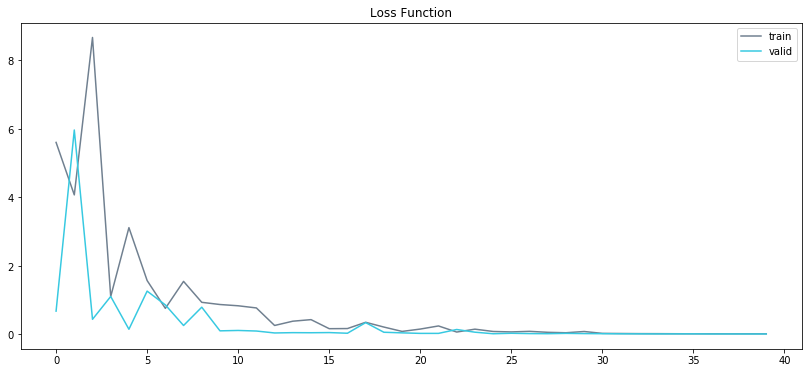

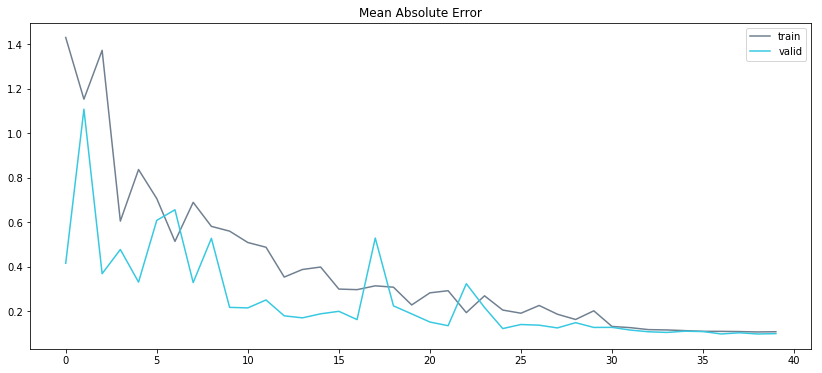

In [69]:
loss_plot(cnn_history1,10)
mae_plot(cnn_history1,10)

In [70]:
cnn_model1.load_weights('cnn_model1.passnyc.hdf5')

y_train_cnn1 = cnn_model1.predict(X_train1.reshape(-1,138,1))
y_valid_cnn1 = cnn_model1.predict(X_valid1.reshape(-1,138,1))
y_test_cnn1 = cnn_model1.predict(X_test1.reshape(-1,138,1))

scores('CNN; Economic Need Index', 
       y_train1, y_valid1, y_test1, y_train_cnn1, y_valid_cnn1, y_test_cnn1)

_______________________________________
CNN; Economic Need Index
_______________________________________
EV score. Train:  0.7361246616423385
EV score. Valid:  0.7345848254198657
EV score. Test:  0.680118220119408
---------
R2 score. Train:  0.7295880577053464
R2 score. Valid:  0.7343986424760895
R2 score. Test:  0.6768794864984327
---------
MSE score. Train:  0.01139590047926858
MSE score. Valid:  0.013781734112743589
MSE score. Test:  0.014095352159485238
---------
MAE score. Train:  0.08466534721701333
MAE score. Valid:  0.096559895704554
MAE score. Test:  0.09774991352021381
---------
MdAE score. Train:  0.07321350336074822
MdAE score. Valid:  0.08564475488662726
MdAE score. Test:  0.08754939198493958


#### The second set of features and targets

In [53]:
def cnn_model2():
    model = Sequential()
        
    model.add(Conv1D(138, 3, padding='valid', input_shape=(138,1)))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(138*4, 3, padding='valid'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(138*8, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5))

    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

cnn_model2 = cnn_model2()

In [54]:
cnn_checkpointer2 = ModelCheckpoint(filepath='cnn_model2.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
cnn_lr_reduction2 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [55]:
cnn_history2 = cnn_model2.fit(X_train2.reshape(-1,138,1), y_train2, 
                              epochs=50, batch_size=64, verbose=2,
                              validation_data=(X_valid2.reshape(-1,138,1), y_valid2),
                              callbacks=[cnn_checkpointer2,cnn_lr_reduction2])

Train on 890 samples, validate on 191 samples
Epoch 1/50
 - 12s - loss: 153781.8129 - mean_absolute_error: 116.9613 - val_loss: 483.4001 - val_mean_absolute_error: 12.0795

Epoch 00001: val_loss improved from inf to 483.40012, saving model to cnn_model2.passnyc.hdf5
Epoch 2/50
 - 10s - loss: 557.0368 - mean_absolute_error: 15.6112 - val_loss: 59.0610 - val_mean_absolute_error: 5.1394

Epoch 00002: val_loss improved from 483.40012 to 59.06103, saving model to cnn_model2.passnyc.hdf5
Epoch 3/50
 - 9s - loss: 372.0117 - mean_absolute_error: 13.7202 - val_loss: 485.9724 - val_mean_absolute_error: 12.3540

Epoch 00003: val_loss did not improve from 59.06103
Epoch 4/50
 - 10s - loss: 239.5806 - mean_absolute_error: 11.0541 - val_loss: 129.3242 - val_mean_absolute_error: 9.5735

Epoch 00004: val_loss did not improve from 59.06103
Epoch 5/50
 - 10s - loss: 225.9590 - mean_absolute_error: 10.6295 - val_loss: 78.1107 - val_mean_absolute_error: 7.7888

Epoch 00005: val_loss did not improve from 5


Epoch 00044: val_loss did not improve from 0.35782
Epoch 45/50
 - 12s - loss: 0.4293 - mean_absolute_error: 0.4975 - val_loss: 0.3633 - val_mean_absolute_error: 0.4215

Epoch 00045: val_loss did not improve from 0.35782
Epoch 46/50
 - 12s - loss: 0.4571 - mean_absolute_error: 0.4960 - val_loss: 0.3756 - val_mean_absolute_error: 0.4248

Epoch 00046: val_loss did not improve from 0.35782
Epoch 47/50
 - 12s - loss: 0.4245 - mean_absolute_error: 0.4797 - val_loss: 0.3837 - val_mean_absolute_error: 0.4249

Epoch 00047: val_loss did not improve from 0.35782

Epoch 00047: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 48/50
 - 12s - loss: 0.4354 - mean_absolute_error: 0.4845 - val_loss: 0.3754 - val_mean_absolute_error: 0.4228

Epoch 00048: val_loss did not improve from 0.35782
Epoch 49/50
 - 11s - loss: 0.4217 - mean_absolute_error: 0.4891 - val_loss: 0.3656 - val_mean_absolute_error: 0.4190

Epoch 00049: val_loss did not improve from 0.35782
Epoch 50/50
 - 12s - l

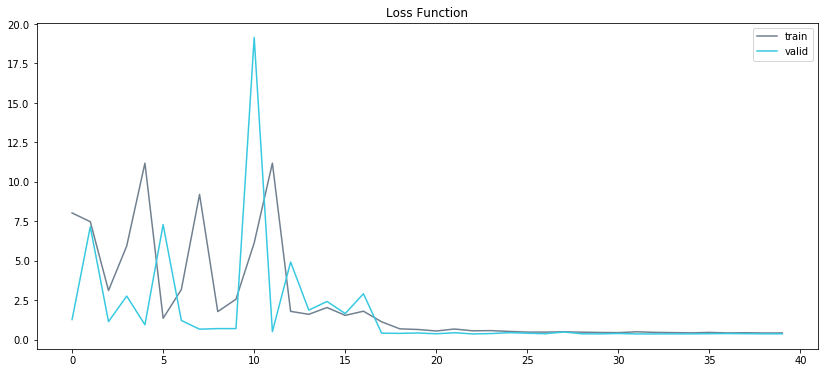

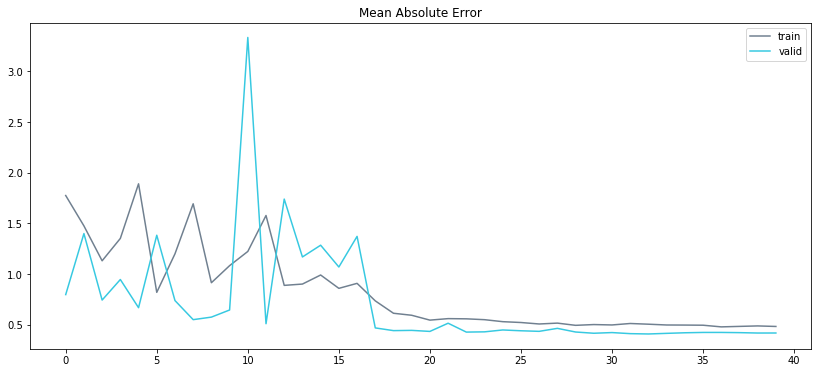

In [56]:
loss_plot(cnn_history2,20)
mae_plot(cnn_history2,20)

In [57]:
cnn_model2.load_weights('cnn_model2.passnyc.hdf5')

y_train_cnn2 = cnn_model2.predict(X_train2.reshape(-1,138,1))
y_valid_cnn2 = cnn_model2.predict(X_valid2.reshape(-1,138,1))
y_test_cnn2 = cnn_model2.predict(X_test2.reshape(-1,138,1))

scores('CNN; School Income Estimate', 
       y_train2, y_valid2, y_test2, y_train_cnn2, y_valid_cnn2, y_test_cnn2)

_______________________________________
CNN; School Income Estimate
_______________________________________
EV score. Train:  0.539300990857384
EV score. Valid:  0.5903959323143508
EV score. Test:  0.5556810083530278
---------
R2 score. Train:  0.535065178248976
R2 score. Valid:  0.5886704287096898
R2 score. Test:  0.5542731416701601
---------
MSE score. Train:  0.34377370609779245
MSE score. Valid:  0.35782008269018056
MSE score. Test:  0.2965876641451619
---------
MAE score. Train:  0.4305543644926712
MAE score. Valid:  0.41286416641936735
MAE score. Test:  0.42463524454367685
---------
MdAE score. Train:  0.3464674658270752
MdAE score. Valid:  0.35768368803812506
MdAE score. Test:  0.37346039473664383


### RNN
#### The first set of features and targets

In [139]:
def rnn_model1():
    model = Sequential()
    
    model.add(LSTM(138, return_sequences=True, input_shape=(1,138)))
    model.add(LSTM(138*4, return_sequences=False)) 
    
    model.add(Dense(138*8, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.25))
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])     
    return model 

rnn_model1 = rnn_model1()

In [140]:
rnn_checkpointer1 = ModelCheckpoint(filepath='rnn_model1.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
rnn_lr_reduction1 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [141]:
rnn_history1 = rnn_model1.fit(X_train1.reshape(-1,1,138), y_train1, 
                              epochs=30, batch_size=64, verbose=2,
                              validation_data=(X_valid1.reshape(-1,1,138), y_valid1),
                              callbacks=[rnn_checkpointer1,rnn_lr_reduction1])

Train on 890 samples, validate on 191 samples
Epoch 1/30
 - 8s - loss: 0.1024 - mean_absolute_error: 0.2315 - val_loss: 0.0287 - val_mean_absolute_error: 0.1368

Epoch 00001: val_loss improved from inf to 0.02872, saving model to rnn_model1.passnyc.hdf5
Epoch 2/30
 - 1s - loss: 0.0229 - mean_absolute_error: 0.1214 - val_loss: 0.0367 - val_mean_absolute_error: 0.1538

Epoch 00002: val_loss did not improve from 0.02872
Epoch 3/30
 - 1s - loss: 0.0281 - mean_absolute_error: 0.1356 - val_loss: 0.0145 - val_mean_absolute_error: 0.1004

Epoch 00003: val_loss improved from 0.02872 to 0.01445, saving model to rnn_model1.passnyc.hdf5
Epoch 4/30
 - 1s - loss: 0.0230 - mean_absolute_error: 0.1201 - val_loss: 0.0190 - val_mean_absolute_error: 0.1160

Epoch 00004: val_loss did not improve from 0.01445
Epoch 5/30
 - 1s - loss: 0.0198 - mean_absolute_error: 0.1143 - val_loss: 0.0136 - val_mean_absolute_error: 0.0930

Epoch 00005: val_loss improved from 0.01445 to 0.01359, saving model to rnn_model1.p

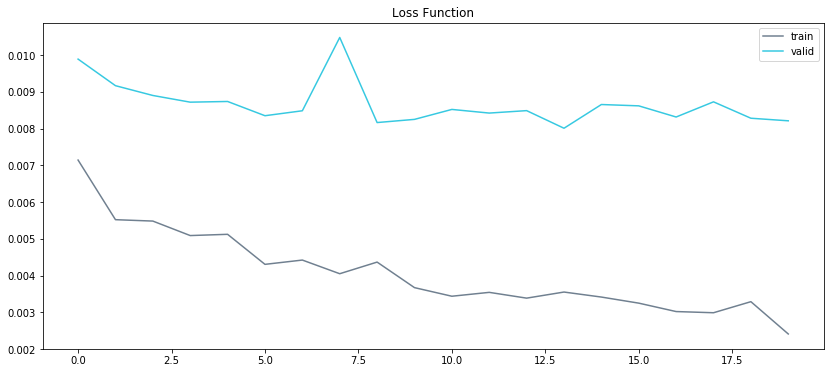

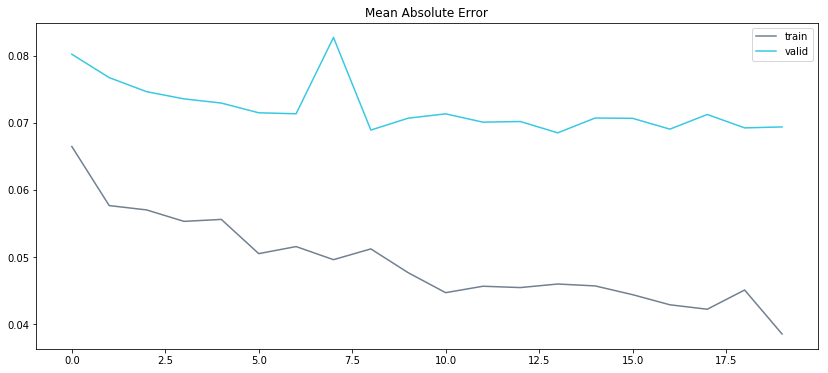

In [142]:
loss_plot(rnn_history1,10)
mae_plot(rnn_history1,10)

In [143]:
rnn_model1.load_weights('rnn_model1.passnyc.hdf5')

y_train_rnn1 = rnn_model1.predict(X_train1.reshape(-1,1,138))
y_valid_rnn1 = rnn_model1.predict(X_valid1.reshape(-1,1,138))
y_test_rnn1 = rnn_model1.predict(X_test1.reshape(-1,1,138))

scores('RNN; Economic Need Index', 
       y_train1, y_valid1, y_test1, y_train_rnn1, y_valid_rnn1, y_test_rnn1)

_______________________________________
RNN; Economic Need Index
_______________________________________
EV score. Train:  0.9539626964504428
EV score. Valid:  0.8458873400590232
EV score. Test:  0.7980317687144037
---------
R2 score. Train:  0.9539114816397409
R2 score. Valid:  0.8456096218234197
R2 score. Test:  0.7980311903250554
---------
MSE score. Train:  0.0019422964977565604
MSE score. Valid:  0.00801113052068648
MSE score. Test:  0.008810401626161639
---------
MAE score. Train:  0.03339443826697292
MAE score. Valid:  0.06848899239644954
MAE score. Test:  0.07127390312274712
---------
MdAE score. Train:  0.02630223321914671
MdAE score. Valid:  0.054291662931442275
MdAE score. Test:  0.05546252965927123


#### The second set of features and targets

In [144]:
def rnn_model2():
    model = Sequential()
    
    model.add(LSTM(138, return_sequences=True, input_shape=(1,138)))
    model.add(LSTM(138*4, return_sequences=False)) 
    
    model.add(Dense(138*8, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.25))
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])     
    return model 

rnn_model2 = rnn_model2()

In [145]:
rnn_checkpointer2 = ModelCheckpoint(filepath='rnn_model2.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
rnn_lr_reduction2 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [146]:
rnn_history2 = rnn_model2.fit(X_train2.reshape(-1,1,138), y_train2, 
                              epochs=30, batch_size=64, verbose=2,
                              validation_data=(X_valid2.reshape(-1,1,138), y_valid2),
                              callbacks=[rnn_checkpointer2,rnn_lr_reduction2])

Train on 890 samples, validate on 191 samples
Epoch 1/30
 - 8s - loss: 0.5661 - mean_absolute_error: 0.5536 - val_loss: 0.4078 - val_mean_absolute_error: 0.4445

Epoch 00001: val_loss improved from inf to 0.40779, saving model to rnn_model2.passnyc.hdf5
Epoch 2/30
 - 1s - loss: 0.3712 - mean_absolute_error: 0.4410 - val_loss: 0.4207 - val_mean_absolute_error: 0.4281

Epoch 00002: val_loss did not improve from 0.40779
Epoch 3/30
 - 1s - loss: 0.3041 - mean_absolute_error: 0.3941 - val_loss: 0.3570 - val_mean_absolute_error: 0.4333

Epoch 00003: val_loss improved from 0.40779 to 0.35698, saving model to rnn_model2.passnyc.hdf5
Epoch 4/30
 - 1s - loss: 0.3165 - mean_absolute_error: 0.4166 - val_loss: 0.3674 - val_mean_absolute_error: 0.4096

Epoch 00004: val_loss did not improve from 0.35698
Epoch 5/30
 - 1s - loss: 0.2772 - mean_absolute_error: 0.3832 - val_loss: 0.5373 - val_mean_absolute_error: 0.5942

Epoch 00005: val_loss did not improve from 0.35698
Epoch 6/30
 - 1s - loss: 0.2514 -

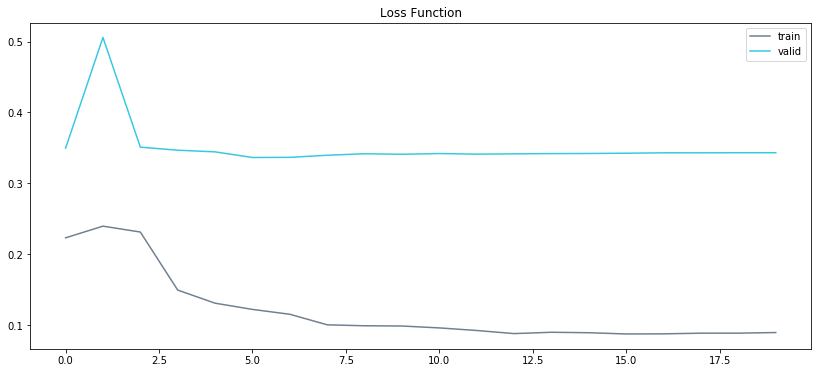

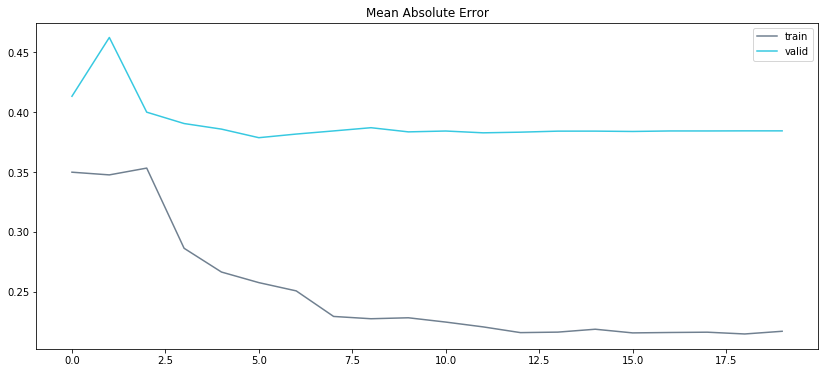

In [147]:
loss_plot(rnn_history2,10)
mae_plot(rnn_history2,10)

In [148]:
rnn_model2.load_weights('rnn_model2.passnyc.hdf5')

y_train_rnn2 = rnn_model2.predict(X_train2.reshape(-1,1,138))
y_valid_rnn2 = rnn_model2.predict(X_valid2.reshape(-1,1,138))
y_test_rnn2 = rnn_model2.predict(X_test2.reshape(-1,1,138))

scores('RNN; School Income Estimate', 
       y_train2, y_valid2, y_test2, y_train_rnn2, y_valid_rnn2, y_test_rnn2)

_______________________________________
RNN; School Income Estimate
_______________________________________
EV score. Train:  0.7515872090341521
EV score. Valid:  0.6353005886159062
EV score. Test:  0.5371041612346767
---------
R2 score. Train:  0.75086839939337
R2 score. Valid:  0.6349480791873169
R2 score. Test:  0.5365581508507318
---------
MSE score. Train:  0.18420838715427454
MSE score. Valid:  0.3175626495358677
MSE score. Test:  0.3083752592817315
---------
MAE score. Train:  0.31957846218933184
MAE score. Valid:  0.3757153416015772
MAE score. Test:  0.4168680864980434
---------
MdAE score. Train:  0.2549636604104878
MdAE score. Valid:  0.255613455450145
MdAE score. Test:  0.3065326377399791


## &#x1F310; &nbsp;  Let's Go Ahead
It' s time to move to the next step.

The results obtained could be a base for several generalizing assumptions:

1) Neural networks such as a multilayer perceptron (MLP) and a recurrent neural network (RNN) better than a convolutional neural network (CNN) cope with the prediction of regression in the presence of mixed data (financial, sociological, etc.)

2) Characteristics of the educational process and results, social environment, ethnic composition, administrative affiliation are sufficient to predict the level of the indicator "Economic Need Index".

3) The same variables are not enough for predicting "School Income Estimate". The information must be supplemented with indicators of economic activity in general for the state and the economic situation in the district adjacent to the school.